In [42]:
import pandas as pd
import numpy as np
from process import TextNormalizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import nltk
import random
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report


data = pd.read_csv("../IMDB-Dataset-GoogleTranslate-Processed.csv")
review, sentiment = data["review"], data["sentiment"]


# Some reviews translated using Miðeind could not be directly translated, we encountered issues when reviews had text such as \*\*\* SPOILERS \*\*\* in them and the translation API gave us results that were full of asterisk(*) AND OTHER ISSUES TO NOTE HERE

# Removed all HTML
# Replace multiple punctations into a single(like ....... into . or ,,,,,, or , or !!!!!  into !)
# Watch out that there is space after a punctuation
# Remove asterisk
# Split on punctuations and ! and ?
# Chunk in 128 characters
# If there is no punctuation we add a punctuation
#<img src="sentiment.jpg" width="400" height="400">
# Translate 128 at once, proved not to be slower and we get more accurate translation

def make_autopct(values):
    def _autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}% ({v:d})'.format(p=pct, v=val)
    return _autopct


# plot = data.sentiment.value_counts().plot(
#     kind="pie", autopct=make_autopct(data.sentiment.value_counts()),
#     title="Google Translate Sentiment"
# );

#plot.get_figure().savefig("sentiment.jpg")


tuned_parameters = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__fit_prior': (True, False),
}

score = 'f1_macro'

pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=tuned_parameters,
    n_iter=100,
    random_state=0,
    scoring=score,
    cv=5,
    n_jobs=-1,
    verbose=3,
)
grid_search = GridSearchCV(estimator=pipeline, 
                           param_grid=tuned_parameters, 
                           cv=5, 
                           scoring=score,
                           verbose=3,
                           n_jobs=-1
)

x_train, x_test, y_train, y_test = train_test_split(
    review, sentiment, test_size=0.2, random_state=42)

print("Random fit")
random_search.fit(x_train, y_train)
print("Random Search Done")
print(random_search.best_params_)
print(random_search.best_score_)
print(random_search.best_estimator_)
print(classification_report(y_test, random_search.predict(x_test), digits=4))

print("Grid fit")
grid_search.fit(x_train, y_train)
print("Grid Search Done")
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(classification_report(y_test, grid_search.predict(x_test), digits=4))


Random fit


InvalidParameterError: The 'cv' parameter of RandomizedSearchCV must be an int in the range [2, inf), an object implementing 'split' and 'get_n_splits', an iterable or None. Got 1 instead.

{'vect__norm': 'l2', 'vect__ngram_range': (1, 2), 'vect__min_df': 1, 'vect__max_df': 0.6, 'clf__fit_prior': True, 'clf__class_prior': None, 'clf__alpha': 0.2}
0.8904499999999999
Pipeline(steps=[('vect', TfidfVectorizer(max_df=0.6, ngram_range=(1, 2))),
                ('clf', MultinomialNB(alpha=0.2))])
              precision    recall  f1-score   support

    negative     0.8829    0.9114    0.8969      4978
    positive     0.9093    0.8801    0.8945      5022

    accuracy                         0.8957     10000
   macro avg     0.8961    0.8958    0.8957     10000
weighted avg     0.8961    0.8957    0.8957     10000



In [40]:
pipeline_1 = Pipeline(
    [
        ("vect", TfidfVectorizer(
            norm='l2',
            ngram_range=(1,2),
            min_df=1,
            max_df=0.6
        )),
        ("clf", MultinomialNB(
            fit_prior=True,
            class_prior=None,
            alpha=0.2
        ))
    ]
)

pipeline_2 = Pipeline(
    [
        ("vect", CountVectorizer(
            ngram_range=(1,2),
            min_df=1,
            max_df=0.6
        )),
        ("tfidf", TfidfTransformer(
            norm='l1',
            use_idf=True
        )),
        ("clf", MultinomialNB(
            alpha=0.01
        ))
    ]
)

pipeline_1.fit(x_train, y_train)
pipeline_2.fit(x_train, y_train)

print(pipeline_1.score(x_test, y_test))
print(pipeline_2.score(x_test, y_test))



0.8957
0.8961


In [38]:
#pred_1 = pipeline_1.transform(x_test)
#pred_2 = pipeline_2.transform(x_test)





0.8957
0.8959


In [13]:
print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)
print(classification_report(y_test, clf.predict(x_test), digits=4))

{'clf__alpha': 0.01, 'tfidf__norm': 'l1', 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
0.8944861271796014
Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(norm='l1')),
                ('clf', MultinomialNB(alpha=0.01))])
              precision    recall  f1-score   support

    negative     0.8851    0.9088    0.8968      4978
    positive     0.9071    0.8831    0.8950      5022

    accuracy                         0.8959     10000
   macro avg     0.8961    0.8960    0.8959     10000
weighted avg     0.8962    0.8959    0.8959     10000



In [29]:
from process import TextNormalizer
tn = TextNormalizer()
def predict(txt):
    normalize = tn.process(txt)
    predict = clf.predict([normalize])
    return predict

print(predict("Þessi mynd er afar frábær"))


['positive']


In [36]:


# Train is 40000(80%) and test is 10000(20%)
X_train, X_test, y_train, y_test = train_test_split(review, sentiment, test_size=0.2, random_state=random.randint(0, 100))

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_tfidf, y_train)

pred = naive_bayes.predict(X_test_tfidf)
print(accuracy_score(y_test, pred))

def predict(txt):
    t = tfidf_vectorizer.transform([txt])
    p = naive_bayes.predict(t)
    return t, p
t, p = predict("Þessi mynd er ömurleg")




0.8599


  (0, 175561)	0.054634370720094354
  (0, 175548)	0.018022321424518678
  (0, 175380)	0.04277143493626734
  (0, 175226)	0.061853149611846694
  (0, 174552)	0.019140982286703134
  (0, 173483)	0.03704234121967358
  (0, 173473)	0.08133957917063575
  (0, 173381)	0.01939705418841087
  (0, 173380)	0.08788261543859556
  (0, 173378)	0.04384758018921646
  (0, 173364)	0.03146985425142364
  (0, 173348)	0.015104305935874543
  (0, 172202)	0.018898681335498657
  (0, 172055)	0.055694318909460354
  (0, 170662)	0.05329348017026584
  (0, 168451)	0.051177136052094854
  (0, 166721)	0.01525036369233653
  (0, 166627)	0.02966350265811111
  (0, 164030)	0.03571772190789893
  (0, 163549)	0.027556571611609865
  (0, 160048)	0.03554077117144602
  (0, 160038)	0.03820704943472825
  (0, 160037)	0.03179397275737021
  (0, 159521)	0.33775407937745755
  (0, 157645)	0.010421935272450418
  :	:
  (0, 31532)	0.02565175986706585
  (0, 30743)	0.030845085604407057
  (0, 30352)	0.02707969239091615
  (0, 30292)	0.034328548902114744


In [41]:
t, p = predict("Næstsíðasta samstarf leikstjórans Anthonys Mann og stjörnunnar James Stewart (að undanskildum þeim fáu dögum sem Mann vann að Night Passage áður en hann skildi við stjörnuna við minni en vinsamlegar aðstæður), The Far Country telur að meginsvipur þess bjóði upp á aðra mynd af útsmoginni manneskju sem dregin er ófús til að leysa sig úr ástarsorginni og berst við hana í hvert fótmál. Í þetta sinn er hann nautgripaökumaður sem sýnir viðbrögð við vinnuvandanum-ögðin við erfiðum kúaskítum við skotbardaga við enda slóðans-sem verða til þess að seiðandi dómari Roy Bean-skólans í lögfræði og reglu gerir gripi hans upptæka af John McIntire. Hann stelur þeim og fer með þá yfir landamæri Kanada og dregst fljótlega ófúslega inn í vaxandi átök framsóknarmanna og dómarans þegar hann svindlar eða drepur þá út úr kröfum þeirra... Þótt það komi ekki mikið á óvart hvaða leið Stewart snýr í lokin er hann furðulega kaldhæðinn gagnrýnandi á leiðinni og notar jafnvel löngun sína til að láta sig bara í friði til að afsaka sig og vara ekki við hópi framsóknarmanna við yfirvofandi snjóflóði þegar hann hefur möguleika á því vegna þess að það er ekki hans vandamál. Í mesta lagi er í raun bara hár alvörubreidd á milli hans og McIntire, nokkuð sem dómarinn viðurkennir strax, og endurtekur sig í anda félagsskapar sem jafnvel er í anda þess að Stewart ætli að lemja hann. Að mörgu leyti eru þeir bæjarbúar sem leggja trúnað á hann sjálfir líklega of uppteknir-þrátt fyrir að þeir viðurkenni að hann höfði til dauða síns-og betri eðlis er óumdeild viðurkenning á því að sá eini sem getur staðið undir dómnum er næstum jafn slæmur og hann er. Eins og venjulega er lítið um að landsmenn noti einstaka staði til að sýna sig á, þótt sýningin fari fram á lokametrunum, og er myndin nánast fullkomlega fullkomlega fullkomlega uppgerð með stuðningi frá hinum unga manni, og með stuðningi frá hinum rómantísku og rómantísku leikhúsum (þó að flutningur á myndinni sé ekki nema nokkurra sérstakra leikhúsa með stuðningi frá hinum rómantísku og rómantísku meðalmönnum) er hann gerður með því að flytja kvikmyndina í aukahlutverki með Harry Rocks (sem er að margra mati ekki nema eins sérkennilegur og hinn rómantíski meðalmaður í kvikmyndagerð. Því miður er myndin með nokkrum aukahlutverkum frá hinum rómantísku leikhúsum, sem eru gerð af hinum rómantísku leikhúsum í Kanada.")


for i in t:
    for idx in i.indices:
        print(i)
        print(tfidf_vectorizer.get_feature_names_out()[idx])
    



  (0, 175561)	0.054634370720094354
  (0, 175548)	0.018022321424518678
  (0, 175380)	0.04277143493626734
  (0, 175226)	0.061853149611846694
  (0, 174552)	0.019140982286703134
  (0, 173483)	0.03704234121967358
  (0, 173473)	0.08133957917063575
  (0, 173381)	0.01939705418841087
  (0, 173380)	0.08788261543859556
  (0, 173378)	0.04384758018921646
  (0, 173364)	0.03146985425142364
  (0, 173348)	0.015104305935874543
  (0, 172202)	0.018898681335498657
  (0, 172055)	0.055694318909460354
  (0, 170662)	0.05329348017026584
  (0, 168451)	0.051177136052094854
  (0, 166721)	0.01525036369233653
  (0, 166627)	0.02966350265811111
  (0, 164030)	0.03571772190789893
  (0, 163549)	0.027556571611609865
  (0, 160048)	0.03554077117144602
  (0, 160038)	0.03820704943472825
  (0, 160037)	0.03179397275737021
  (0, 159521)	0.33775407937745755
  (0, 157645)	0.010421935272450418
  :	:
  (0, 31532)	0.02565175986706585
  (0, 30743)	0.030845085604407057
  (0, 30352)	0.02707969239091615
  (0, 30292)	0.034328548902114744


In [89]:
# Using occurences of words in a bag of words







X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_tfidf, y_train)


# Create Naive Bayes Classifiers
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
y_pred_mnb = mnb.predict(X_test_tfidf)
print("Multinomial", accuracy_score(y_test, y_pred_mnb))
y_pred_clf = clf.predict(X_test_tfidf)
print("Logistic Regression", accuracy_score(y_test, y_pred_clf))

scores_clf = cross_val_score(clf, X_train_tfidf, y_train, cv=5)
scores_mnb = cross_val_score(mnb, X_train_tfidf, y_train, cv=5)

def test(texts):
    X_new_counts = tfidf_vectorizer.transform(texts)
    return mnb.predict(X_new_counts), clf.predict(X_new_counts)
   

print(test(["Satt að segja fannst mér þessi mynd ekki vera mjög skemmtileg", 
            "Mér fannst þessi mynd geggjuð", 
            "Mér fannst þessi mynd mjög skemmtileg",
            "Ég var skellihlæjandi allan tíman því myndin var svo fyndin"]))


from sklearn.metrics import classification_report
print(scores_clf.mean(), scores_clf.std())
print(scores_mnb.mean(), scores_mnb.std())
print(classification_report(y_test, y_pred_mnb))
print(classification_report(y_test, y_pred_clf))
# 82%

Multinomial 0.8635
Logistic Regression 0.895
(array(['positive', 'negative', 'negative', 'negative'], dtype='<U8'), array(['negative', 'negative', 'negative', 'negative'], dtype='<U8'))
0.893575 0.002832401807653699
0.861675 0.0038847458089300807
              precision    recall  f1-score   support

    negative       0.84      0.89      0.87      4961
    positive       0.88      0.84      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

              precision    recall  f1-score   support

    negative       0.90      0.89      0.89      4961
    positive       0.89      0.90      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.90      0.89     10000



In [84]:
data


,Unnamed: 0,review,sentiment
0,0,hvattur jákvæðum ummælum mynd hérna hlakka hor...,negative
1,1,einn gagnrýnenda hafa nefndur hafa horft aðein...,positive
2,2,yndislegur lítill framleiðsla kvikmyndatækni m...,positive
3,3,love in the time money petter mattei sjónrænn ...,positive
4,4,í grundvallaratriðum fjölskylda lítill strákur...,negative
...,...,...,...
49995,49995,mér finna mynd standa mjög vel það vera ekki s...,positive
49996,49996,enginn búa star trek mynd séu hálist aðdáandi ...,negative
49997,49997,slæmur söguþráður lélegur samræða lélegur leik...,negative
49998,49998,ég kaþólikki nunn kenna grunnskólum kirkjudeil...,negative


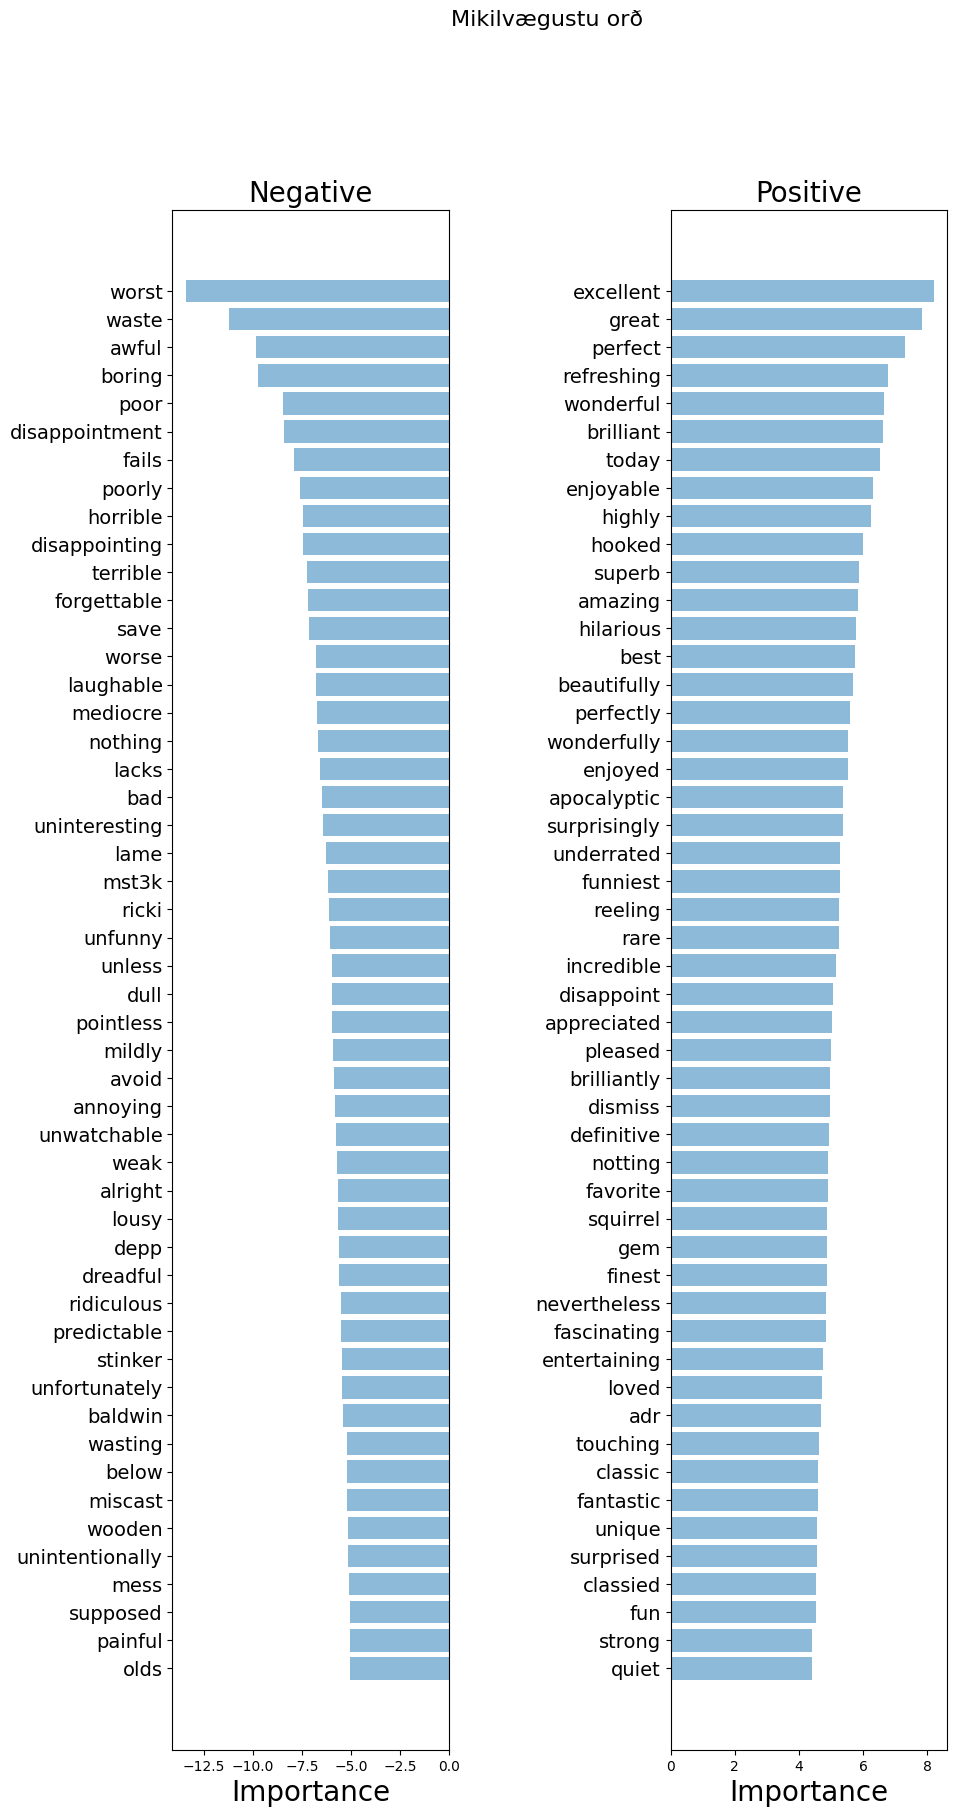

In [90]:
import numpy as np
import matplotlib.pyplot as plt

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 20))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

    
importance = get_most_important_features(tfidf_vectorizer, clf, 50)

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Mikilvægustu orð")

In [24]:
# Term Freqencies
tf_transformer = TfidfTransformer(use_idf=False)



['negative' 'positive' 'positive' 'negative']


In [37]:
reviews, sentiments = data["review"], data["sentiment"]
total_positive, total_negative = sentiments.value_counts()["positive"], sentiments.value_counts()["negative"]
print(len(reviews), len(sentiment), total_positive, total_negative)

50000 2 25000 25000


In [38]:
def sentiment_feature(txt):
    return {'sentiment': txt}

featureset = [(sentiment_feature(sentiment), review) for (review, sentiment) in zip(reviews, sentiments)]
featureset[0:4]

[({'sentiment': 'negative'},
  "Hvattur af jákvæðum ummælum um þessa mynd hérna, hlakkaði ég til að horfa á þessa mynd. Slæm mistök. Ég hef séð 950+ kvikmyndir og þetta er sannarlega ein af þeim verstu - hún er hræðileg á næstum öllum sviðum: klipping, skeið, söguþráður, 'leikur', hljóðrás (eina lag myndarinnar - lame country lag - er spilað nr. minna en fjórum sinnum). Myndin lítur ódýr og viðbjóðslega út og er leiðinleg í öfgakennd. Sjaldan hef ég verið jafn ánægður með að sjá lokaeintök kvikmyndar. Það eina sem kemur í veg fyrir að ég gefi þessu 1-einkunn er Harvey Keitel - þó að þetta sé langt frá hans besta frammistöðu virðist hann að minnsta kosti vera að leggja sig svolítið fram. Einn fyrir Keitel þráhyggju."),
 ({'sentiment': 'positive'},
  'Einn hinna gagnrýnenda hefur nefnt að eftir að hafa horft aðeins á 1 Oz þátt þá verðurðu hrifinn. Þeir hafa rétt fyrir sér, þar sem þetta er nákvæmlega það sem gerðist hjá mér. Það fyrsta sem sló mig við Oz var grimmd hans og óbilandi ofbel

In [36]:
train_set, test_set = featureset[0:40000], featureset[40000:50000]
import nltk
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.0
